# Predicting heart disease

This notebook performs heart disease classification comparing the baseline classifiers of logistic regression, k-nearest neighbors and naive bayes

# Authors

Elnaz Azizi, Charly Watts, Christian Unterrainer

# Imports

In [137]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_recall_curve, f1_score


# Data

## Load data from files

In [138]:
# List of tuples: (filepath, is_space_separated)
# Used to load multiple datasets with potentially different separators
file_info = [
    ('data/processed.cleveland.data', False),
    ('data/processed.switzerland.data', False),
    ('data/reprocessed.hungarian.data', True),  # space-separated
]

# Column names for the dataset(s); assumed to be the same across all files
col_names = [
    'age','sex','cp','trestbps','chol','fbs',
    'restecg','thalach','exang','oldpeak',
    'slope','ca','thal','target'
]

# List to hold the individual dataframes after loading
dataframes = []

# Loop through each file and load it into a pandas DataFrame
for path, is_space_separated in file_info:
    if is_space_separated:
        # Use regex separator for space-separated values (e.g., Hungarian dataset)
        df = pd.read_csv(path, sep=r'\s+', header=None, names=col_names, na_values='?')
    else:
        # Default CSV reading (assumes comma-separated or consistent with pd default)
        df = pd.read_csv(path, header=None, names=col_names, na_values='?')
    dataframes.append(df)  # Store the loaded DataFrame

## Test split and normalize target values

In [139]:
# Prepare train/test split for each dataset
# Note: NaNs are intentionally kept for later imputation in the ML pipeline
splits = []

# Iterate over each DataFrame and corresponding file info
for df, (path, _) in zip(dataframes, file_info):
    # Extract dataset name from file path (e.g., 'processed.cleveland.data')
    dataset_name = path.split('/')[-1]

    # Convert target values to binary:
    # 0 = no heart disease, 1 = presence of heart disease
    df['target'] = df['target'].astype(int).apply(lambda v: 1 if v > 0 else 0)

    # Separate features (X) and label (y)
    x = df.drop(columns='target')
    y = df['target']

    # Stratified train-test split (preserves class distribution)
    x_train, x_test, y_train, y_test = train_test_split(
        x, y,
        test_size=0.2,         # 80% training, 20% testing
        random_state=42,       # Ensures reproducibility
        stratify=y             # Ensures proportional class distribution in train/test
    )

    # Store split data and dataset name for future processing
    splits.append({
        "dataset": dataset_name,
        "x_train": x_train,
        "x_test": x_test,
        "y_train": y_train,
        "y_test": y_test
    })

# Build pipeline

## 1. Column Configuration

In [140]:
# Define feature column types
numeric_cols = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
categorical_cols = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']

## 2. Preprocessing Pipeline

In [141]:
# Numeric preprocessing: impute missing values, then scale
num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Categorical preprocessing: impute with most frequent value, add missingness indicator
cat_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent', add_indicator=True))
])

# Combine both into a column transformer
preprocessor = ColumnTransformer([
    ('num', num_pipe, numeric_cols),
    ('cat', cat_pipe, categorical_cols)
])

## 3. Model Pipelines

In [142]:
# Logistic Regression pipeline
logistic_pipeline = Pipeline([
    ('pre', preprocessor),
    ('clf', LogisticRegression(max_iter=1000))
])

# KNN pipeline
kneighbors_pipeline = Pipeline([
    ('pre', preprocessor),
    ('knn', KNeighborsClassifier())
])

# Naive Bayes pipeline
naive_pipeline = Pipeline([
    ('pre', preprocessor),
    ('nav', GaussianNB())
])

## 4. Hyperparameter Grids

In [143]:
logistic_param_grid = {'clf__C': [0.01, 0.1, 1, 10]}
kneighbors_param_grid = {'knn__n_neighbors': list(range(1, 21))}
naive_param_grid = {}  # No tunable hyperparameters

## 5. Grid Search & Evaluation

In [144]:
# Model name mapped to (pipeline, param grid)
pipelines = {
    "Logistic Regression": (logistic_pipeline, logistic_param_grid),
    "K Nearest Neighbors": (kneighbors_pipeline, kneighbors_param_grid),
    "Naive Bayes": (naive_pipeline, naive_param_grid)
}

results = []

# Loop over each dataset split
for split in splits:
    dataset_name = split["dataset"]
    x_train = split["x_train"]
    y_train = split["y_train"]
    x_test = split["x_test"]
    y_test = split["y_test"]

    # Loop over each model and run GridSearchCV
    for model_name, (pipeline, param_grid) in pipelines.items():
        grid = GridSearchCV(pipeline, param_grid, cv=5, scoring='recall', n_jobs=-1)
        grid.fit(x_train, y_train)
        y_pred = grid.predict(x_test)
        report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)

        results.append({
            "Dataset": dataset_name,
            "Model": model_name,
            "Best Params": grid.best_params_,
            "Recall": report['1']['recall'],
            "Precision": report['1']['precision'],
            "F1-Score": report['1']['f1-score']
        })

## 6. Results Summary

In [145]:
# Convert evaluation results into a DataFrame
results_df = pd.DataFrame(results)
print(results_df)

                      Dataset                Model              Best Params  \
0    processed.cleveland.data  Logistic Regression            {'clf__C': 1}   
1    processed.cleveland.data  K Nearest Neighbors  {'knn__n_neighbors': 3}   
2    processed.cleveland.data          Naive Bayes                       {}   
3  processed.switzerland.data  Logistic Regression         {'clf__C': 0.01}   
4  processed.switzerland.data  K Nearest Neighbors  {'knn__n_neighbors': 9}   
5  processed.switzerland.data          Naive Bayes                       {}   
6  reprocessed.hungarian.data  Logistic Regression           {'clf__C': 10}   
7  reprocessed.hungarian.data  K Nearest Neighbors  {'knn__n_neighbors': 3}   
8  reprocessed.hungarian.data          Naive Bayes                       {}   

     Recall  Precision  F1-Score  
0  0.928571   0.812500  0.866667  
1  0.785714   0.733333  0.758621  
2  0.071429   0.333333  0.117647  
3  1.000000   0.920000  0.958333  
4  1.000000   0.920000  0.958333  

# Experiments

In [146]:
results = []

for split in splits:
    dataset_name = split["dataset"]
    x_test = split["x_test"]
    y_test = split["y_test"]

    for model_name, (pipeline, param_grid) in pipelines.items():
        grid = GridSearchCV(pipeline, param_grid, cv=5, scoring='recall', n_jobs=-1)
        grid.fit(split["x_train"], split["y_train"])
        y_probs = grid.predict_proba(x_test)[:, 1]

        thresholds = np.arange(0.1, 0.9, 0.01)
        f1_scores = [f1_score(y_test, (y_probs >= t).astype(int)) for t in thresholds]
        best_index = np.argmax(f1_scores)
        best_threshold = thresholds[best_index]

        y_pred = (y_probs >= best_threshold).astype(int)
        cm = confusion_matrix(y_test, y_pred)
        report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)

        results.append({
            "dataset": dataset_name,
            "model": model_name,
            "threshold": best_threshold,
            "y_pred": y_pred,
            "y_test": y_test,
            "y_probs": y_probs,
            "cm": cm,
            "report": report
        })


# Plotting

## Confusion Matrix

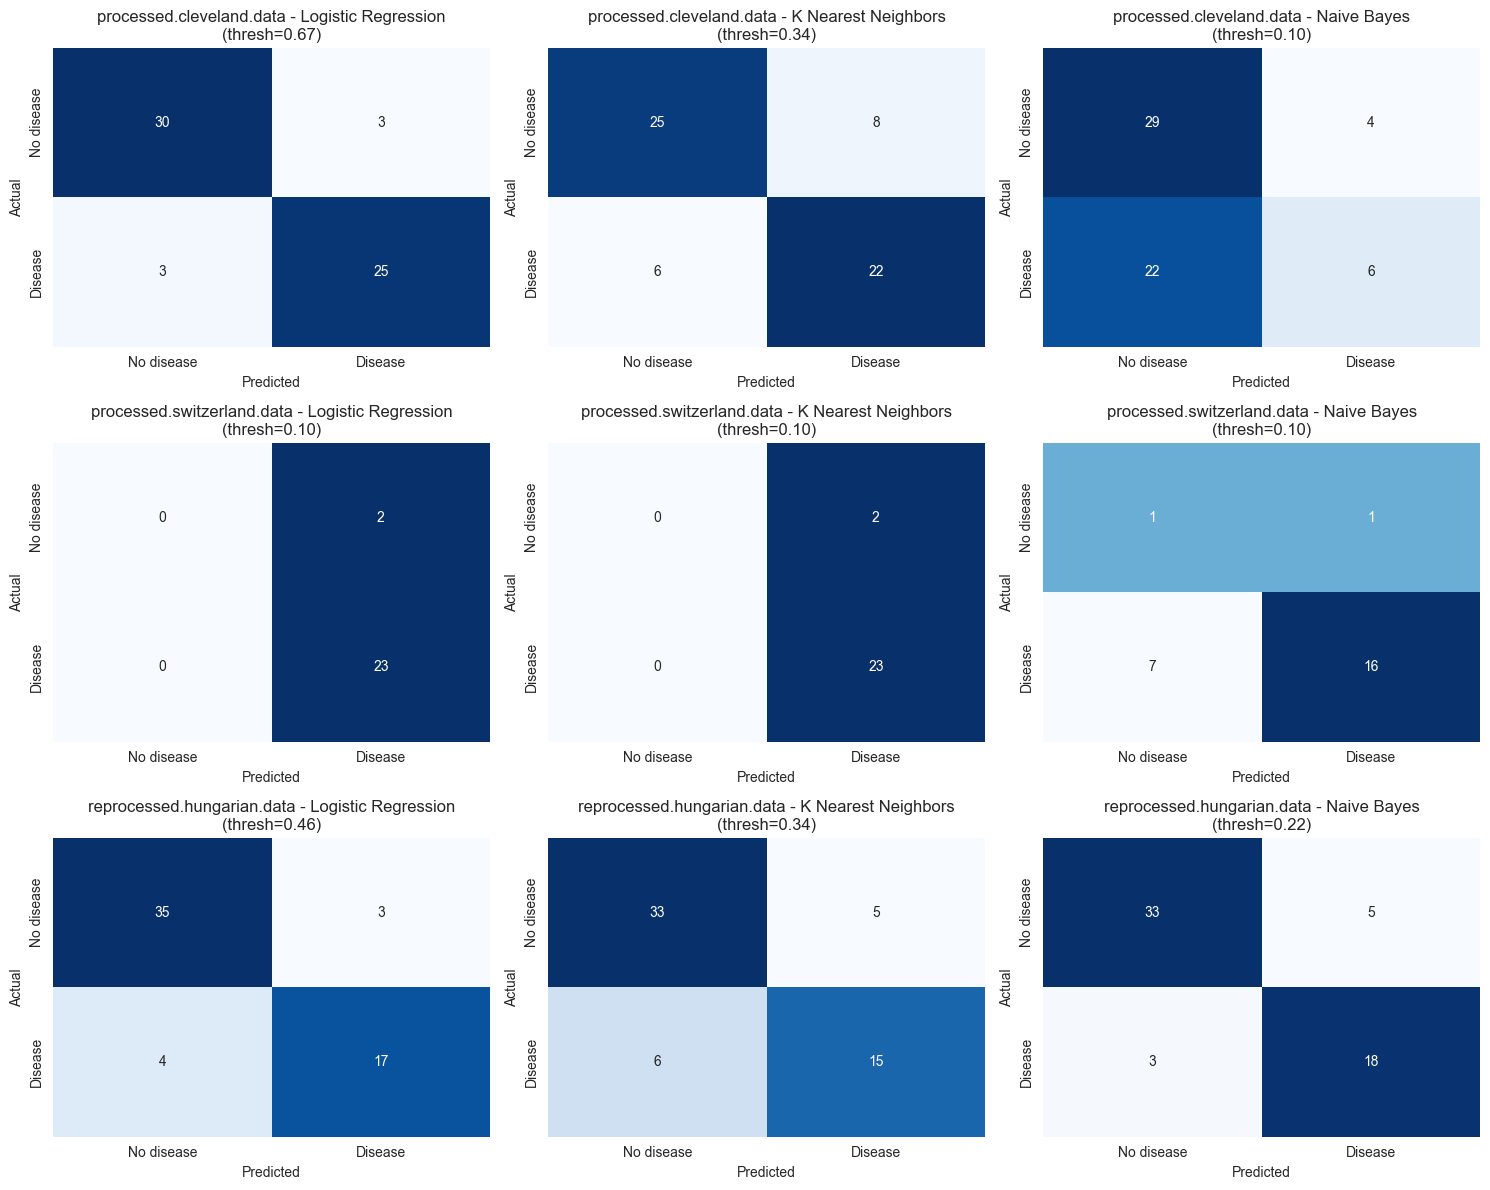

In [147]:
# Plot all confusion matrices in a grid for better overview
num_plots = len(results)
cols = 3  # Number of plots per row
rows = math.ceil(num_plots / cols)

fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 4))

for idx, res in enumerate(results):
    ax = axes[idx // cols, idx % cols]
    cm_norm = res["cm"].astype(float) / res["cm"].sum(axis=1)[:, None]

    sns.heatmap(
        cm_norm,
        annot=res["cm"],
        fmt='d',
        cmap='Blues',
        xticklabels=['No disease', 'Disease'],
        yticklabels=['No disease', 'Disease'],
        ax=ax,
        cbar=False
    )
    ax.set_title(f'{res["dataset"]} - {res["model"]}\n(thresh={res["threshold"]:.2f})')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')

# Hide any unused subplots
for i in range(num_plots, rows * cols):
    fig.delaxes(axes.flatten()[i])

plt.tight_layout()
plt.show()

## P-R Curve

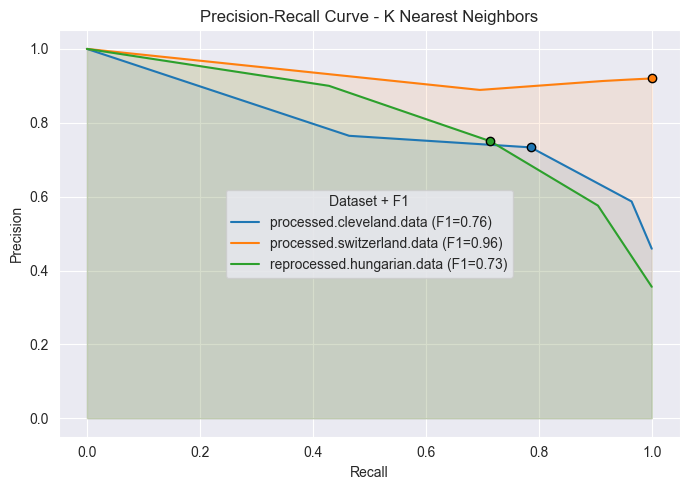

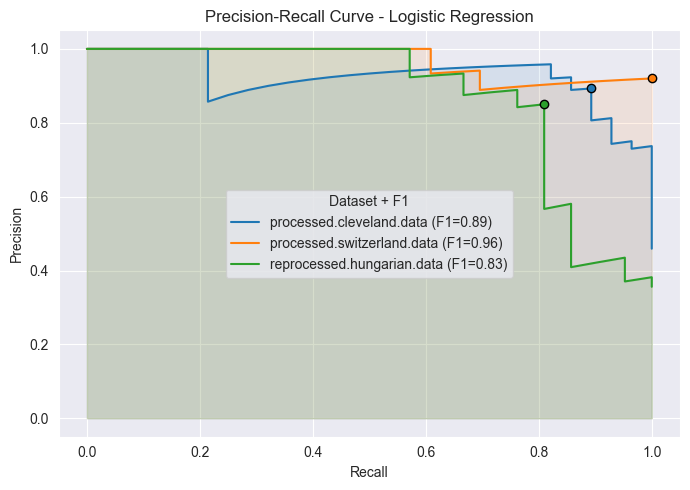

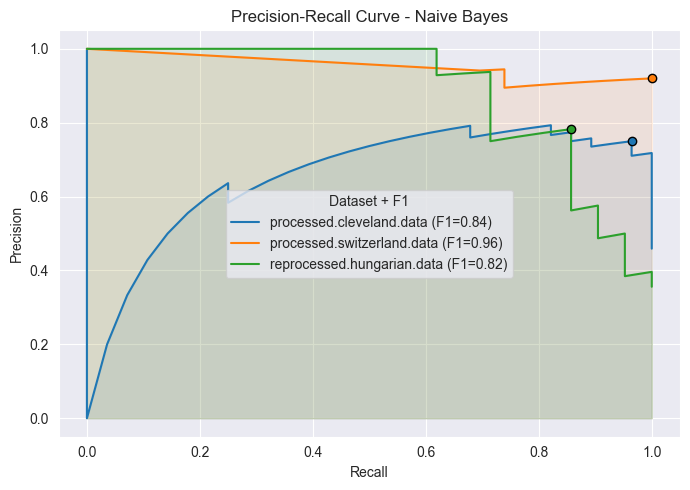

In [148]:
# Consistent color palette
palette = sns.color_palette("tab10")
models = sorted(set(res["model"] for res in results))

for model in models:
    plt.figure(figsize=(7, 5))
    model_results = [res for res in results if res["model"] == model]

    for i, res in enumerate(model_results):
        y_test = res["y_test"]
        y_probs = res["y_probs"]
        dataset = res["dataset"]

        # PR curve + thresholds
        precision, recall, thresholds = precision_recall_curve(y_test, y_probs)
        f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)
        best_idx = np.argmax(f1_scores)
        best_threshold = thresholds[best_idx]
        best_f1 = f1_scores[best_idx]

        # Plot PR curve
        plt.plot(recall, precision, label=f'{dataset} (F1={best_f1:.2f})',
                 color=palette[i % len(palette)])

        # Mark best threshold point
        plt.scatter(recall[best_idx], precision[best_idx], color=palette[i % len(palette)],
                    edgecolor='black', zorder=5)

        # Optional: fill under curve for aesthetics
        plt.fill_between(recall, precision, alpha=0.1, color=palette[i % len(palette)])

    plt.title(f"Precision-Recall Curve - {model}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.grid(True)
    plt.legend(title="Dataset + F1")
    plt.tight_layout()
    plt.show()